In [126]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

In [127]:
warnings.filterwarnings('ignore',category=pd.errors.SettingWithCopyWarning)

In [128]:
data = pd.read_csv('datasets/housing/housing.csv',sep=',')

&nbsp;

## Analise 

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [130]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [131]:
data['ocean_proximity'].value_counts().reset_index()

,ocean_proximity,count
0,<1H OCEAN,9136
1,INLAND,6551
2,NEAR OCEAN,2658
3,NEAR BAY,2290
4,ISLAND,5


In [132]:
data.isna().nunique()

longitude             1
latitude              1
housing_median_age    1
total_rooms           1
total_bedrooms        2
population            1
households            1
median_income         1
median_house_value    1
ocean_proximity       1
dtype: int64

> `total_bedrooms` possui valores `NaN`/`Nulo`

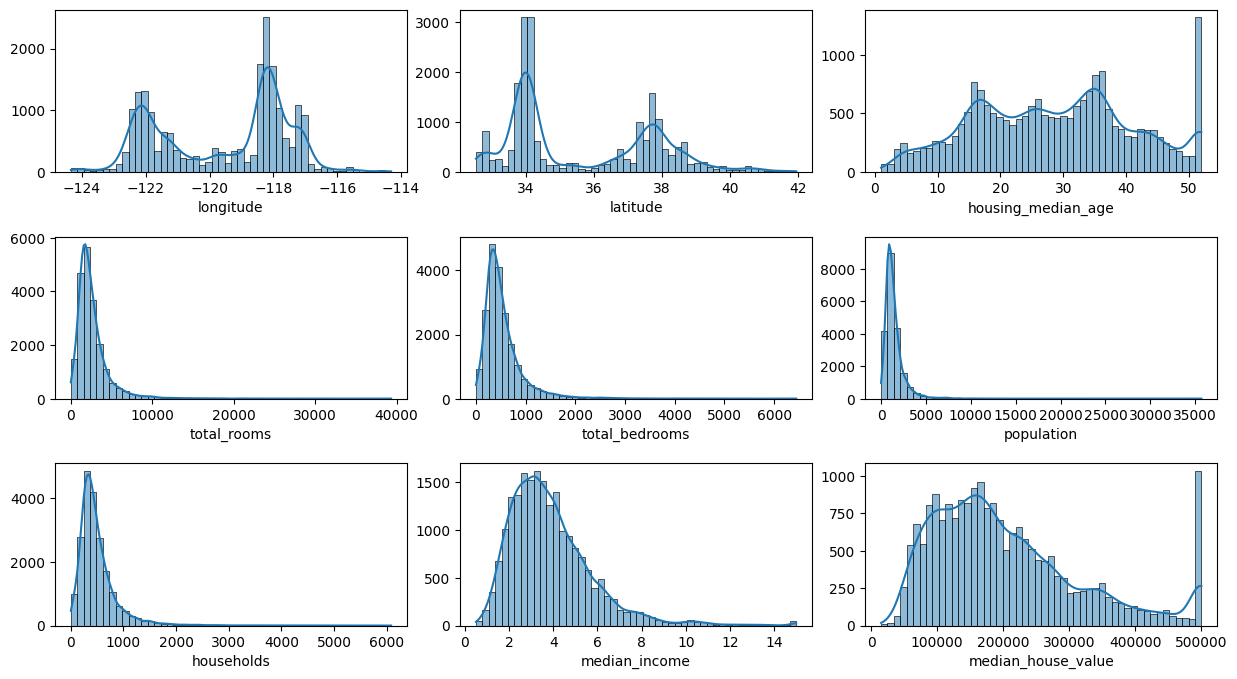

In [133]:
fig , ax = plt.subplots(3,3,figsize=(15,8))
colunas  = data.select_dtypes(exclude=['object']).columns
for coluna , axis in zip(colunas , ax.flatten()):
    sea.histplot(data[coluna],ax=axis,kde=True,bins=50)
    axis.set_ylabel('')
fig.subplots_adjust(hspace=0.4,wspace=0.15)
plt.show()

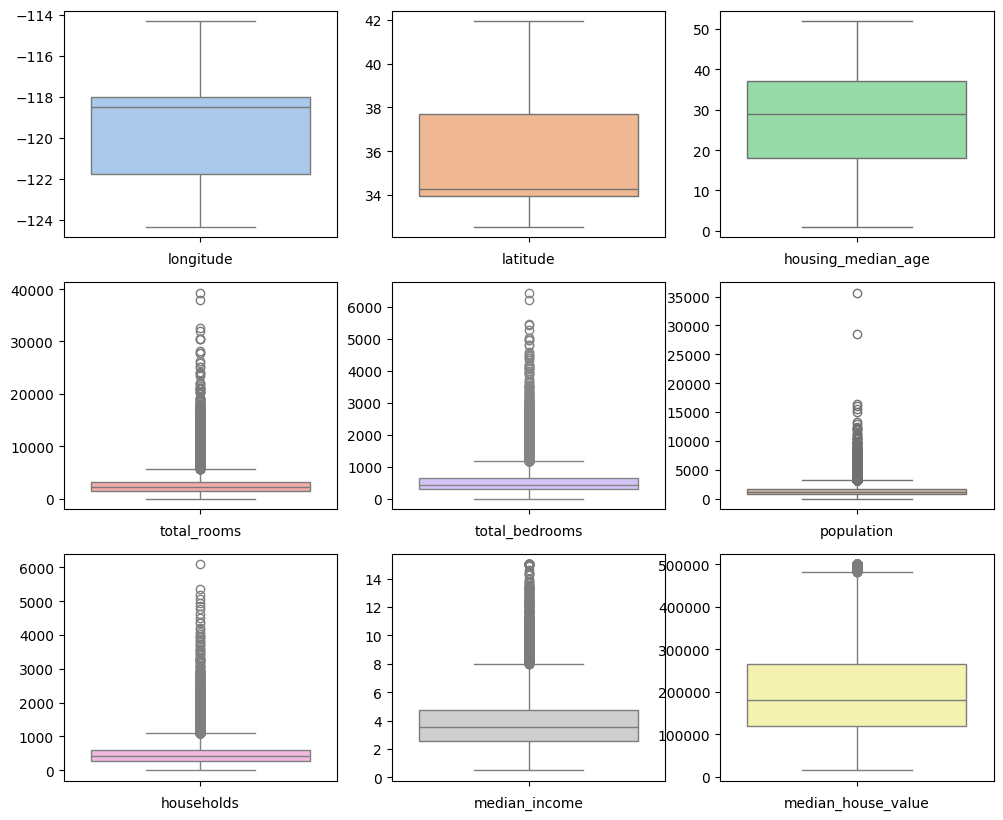

In [134]:
fig , ax = plt.subplots(3,3,figsize=(12,10))
columns  = data.select_dtypes(exclude=['object']).columns
colors   = sea.color_palette('pastel',n_colors=9)

for colunas , axi , color in zip(columns,ax.flatten(),colors):
    sea.boxplot(data[colunas],ax=axi,color=color)
    axi.set_xlabel(colunas)
    axi.set_ylabel('')
plt.show()

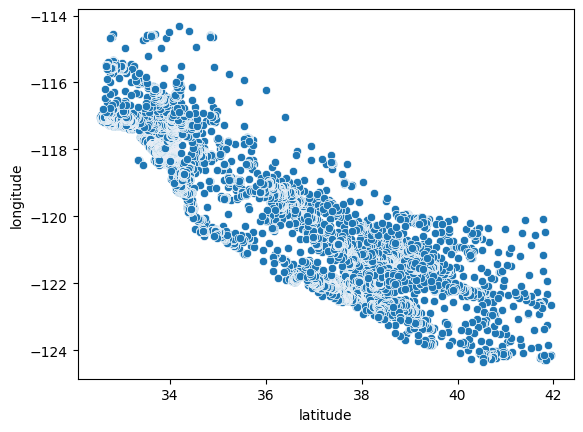

In [135]:
sea.scatterplot(x=data['latitude'],y=data['longitude'])
plt.show()

In [136]:
from sklearn.preprocessing   import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

In [137]:
dataset = pd.read_csv(r'datasets/housing/housing.csv')

Discretização do atributo renda média

In [138]:
bins = [0,1.5,3.0,4.5,6,np.inf]
dataset['categoriaRenda'] = pd.cut(dataset['median_income'],bins=bins,labels=[1,2,3,4,5])

In [139]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for ( train , test ) in split.split(dataset,dataset['categoriaRenda']):
    trainDataset = dataset.iloc[train]
    testDataset  = dataset.iloc[test]

In [140]:
trainDataset.drop(columns=['categoriaRenda'],inplace=True)

In [141]:
testDataset.drop(columns=['categoriaRenda'],inplace=True)

In [142]:
datasetpred = trainDataset.copy()

In [143]:
datasetpred.corr(numeric_only=True)['median_house_value'].sort_values()[::-1]

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

## Pré-processamento

In [162]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.linear_model  import LinearRegression
from sklearn.tree          import DecisionTreeRegressor
from sklearn.metrics       import *
from sklearn.impute        import SimpleImputer

In [145]:
Xtrain = trainDataset.drop(columns='median_house_value')
Ytrain = trainDataset['median_house_value']

Xtest = testDataset.drop(columns='median_house_value')
Ytest = testDataset['median_house_value']

In [146]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [147]:
pipelineNumerica = Pipeline([
    ('imputer'           ,SimpleImputer(strategy='median')),
    ('atributosAdicionar',CombinedAttributesAdder()),
    ('padronização'      ,StandardScaler())
])

In [148]:
num  =  list(Xtrain.select_dtypes(exclude=['object']))
char =  list(Xtrain.select_dtypes(include=['object']))
pipelineCategorica = ColumnTransformer([
    ('num',pipelineNumerica,num),
    ('char',OneHotEncoder(),char)
])

In [149]:
Xtrain = pipelineCategorica.fit_transform(Xtrain)
Xtest  = pipelineCategorica.fit_transform(Xtest)

In [150]:
reg = LinearRegression()
reg.fit(Xtrain,Ytrain)

LinearRegression()

In [155]:
pred = reg.predict(Xtest)

In [159]:
mean_absolute_error(Ytest,pred)

49306.817871896914

In [161]:
np.sqrt(mean_squared_error(Ytest,pred))

66975.77789893825

In [165]:
tree = DecisionTreeRegressor()
tree.fit(Xtrain,Ytrain)

DecisionTreeRegressor()

In [166]:
predTree = tree.predict(Xtest)

In [172]:
mean_squared_error(Ytest,predTree,squared=False)

109864.65047566712